In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 1

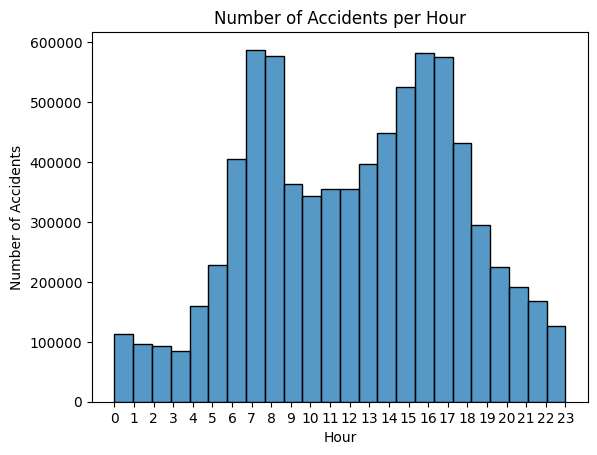

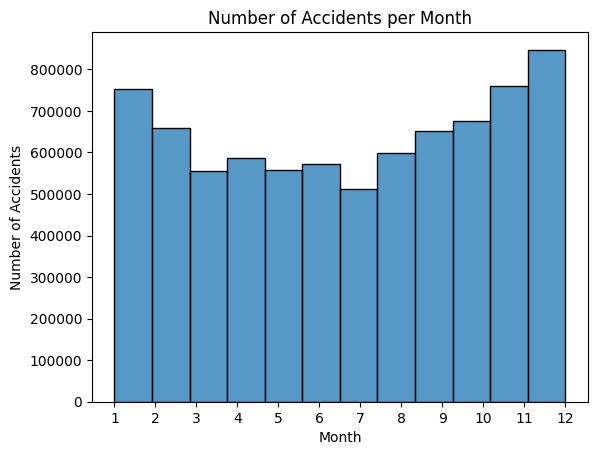

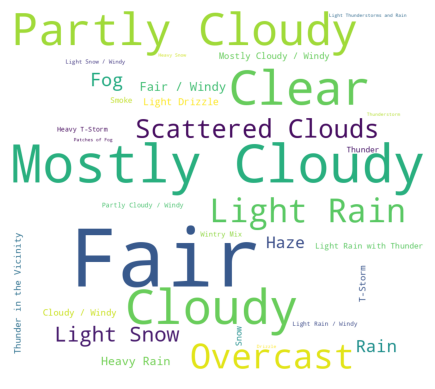

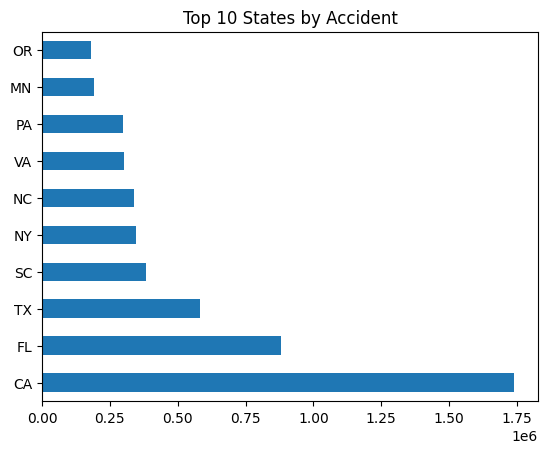

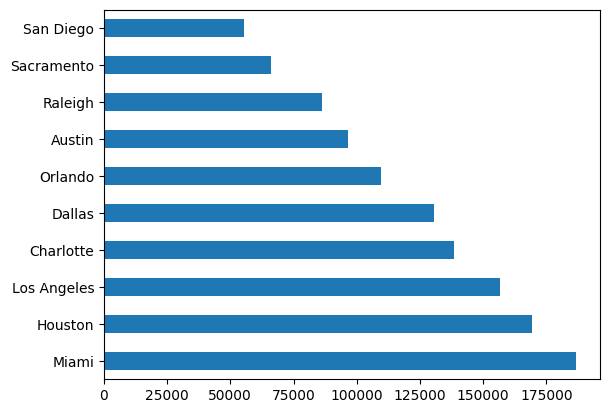

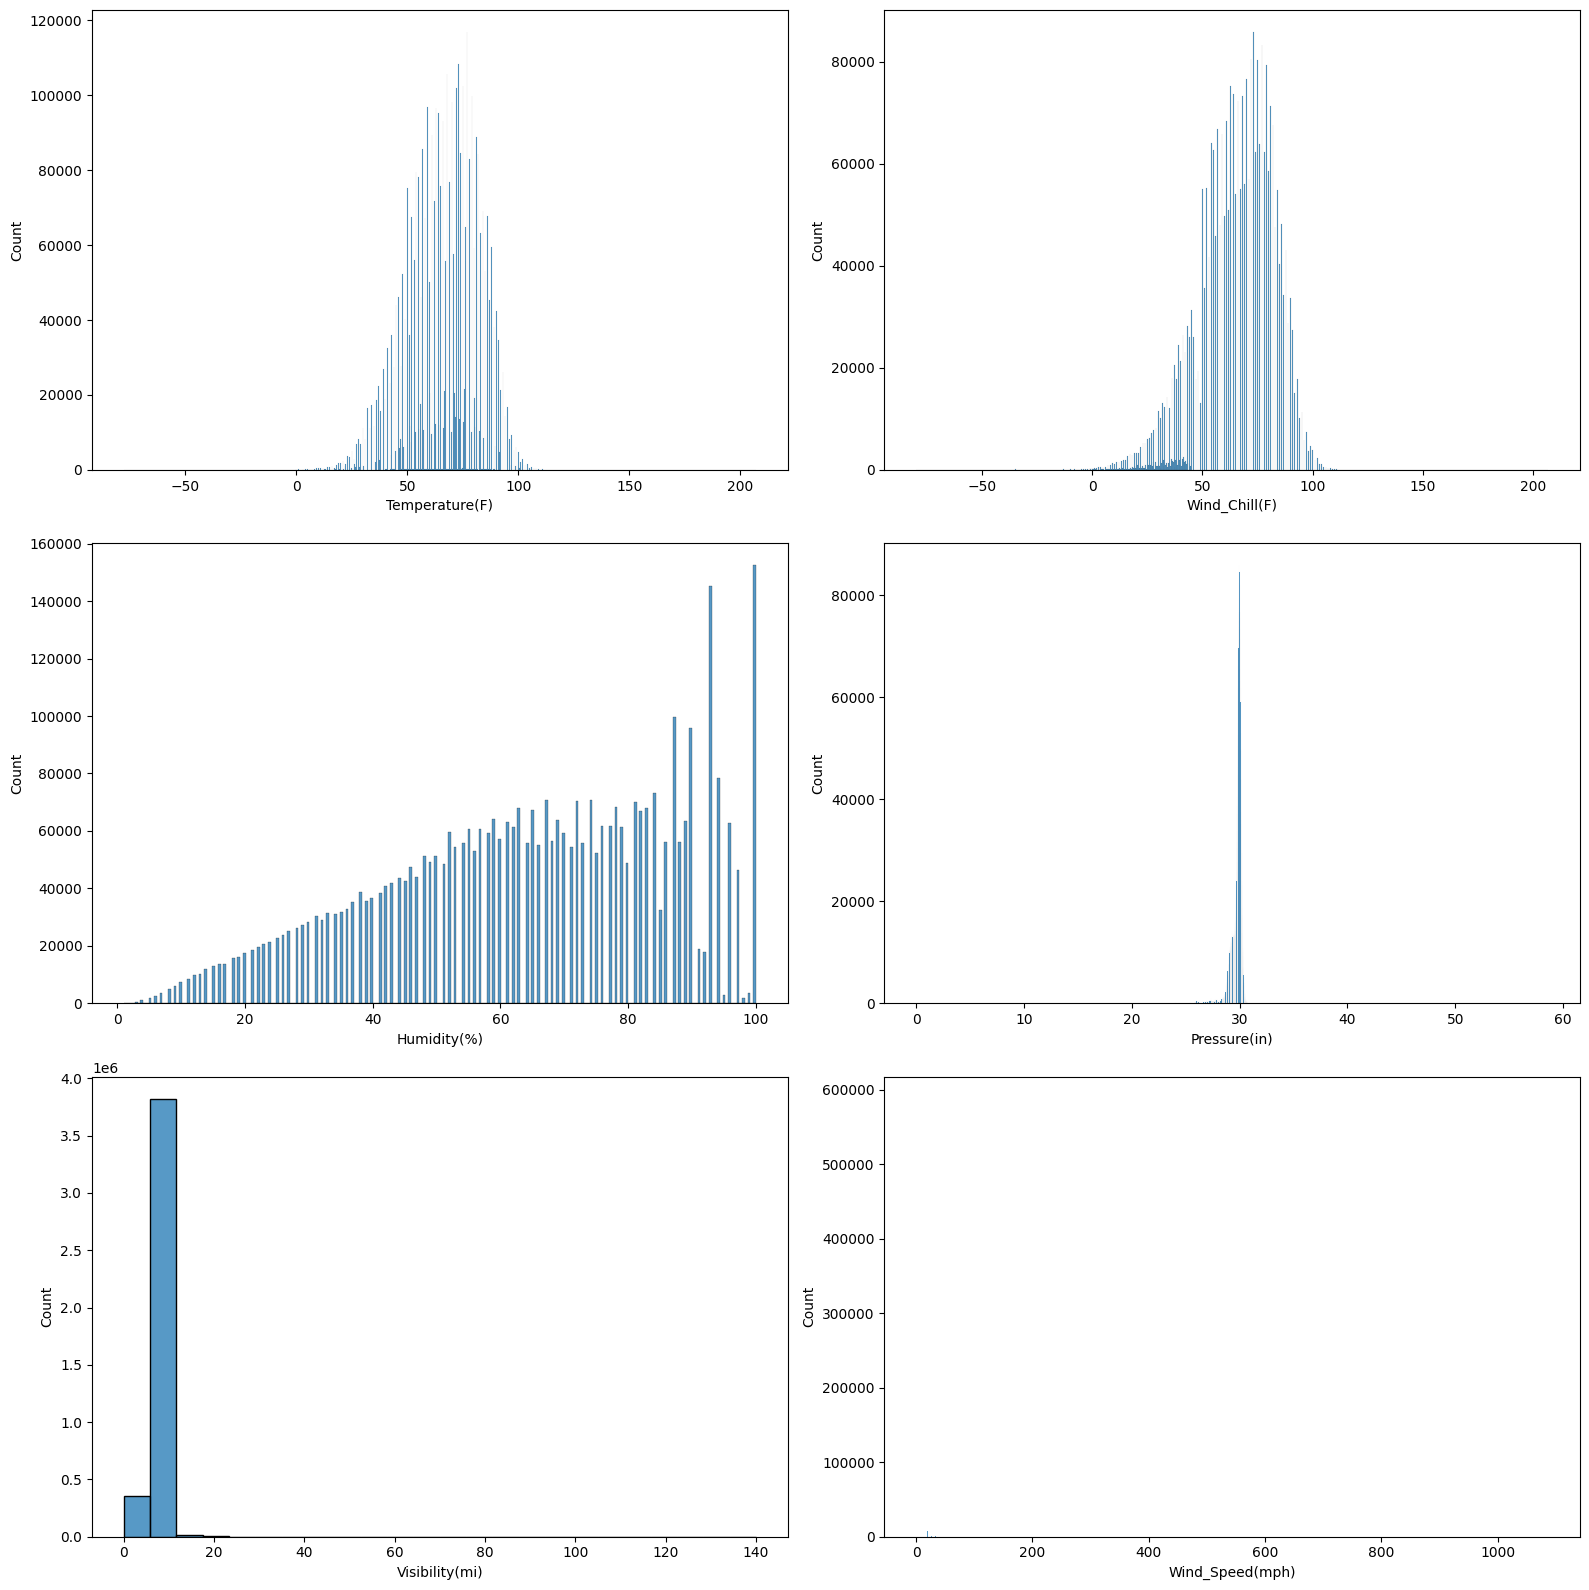

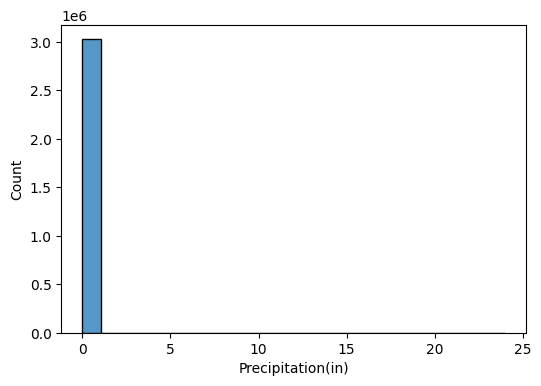

<ipython-input-2-78c18a75bec9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Wind_Speed(mph)'] = new_df.loc[new_df['Wind_Speed(mph)'] > 100, 'Wind_Speed(mph)'] / 10
<ipython-input-2-34f6750243dd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Temperature(F)'].fillna(value=mean_value_temp, inplace=True)
<ipython-input-2-34f6750243dd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4191738 entries, 728 to 7728393
Data columns (total 41 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   ID                     object         
 1   Severity               int64          
 2   Start_Time             datetime64[ns] 
 3   End_Time               datetime64[ns] 
 4   Start_Lat              float64        
 5   Start_Lng              float64        
 6   Distance(mi)           float64        
 7   Description            object         
 8   Street                 object         
 9   City                   object         
 10  County                 object         
 11  State                  object         
 12  Zipcode                object         
 13  Weather_Timestamp      datetime64[ns] 
 14  Temperature(F)         float64        
 15  Wind_Chill(F)          float64        
 16  Humidity(%)            float64        
 17  Pressure(in)           float64        
 18  

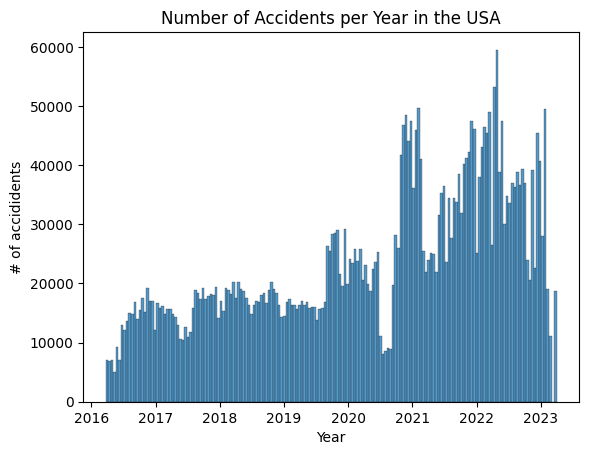

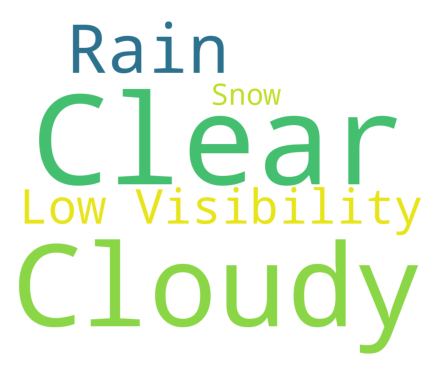

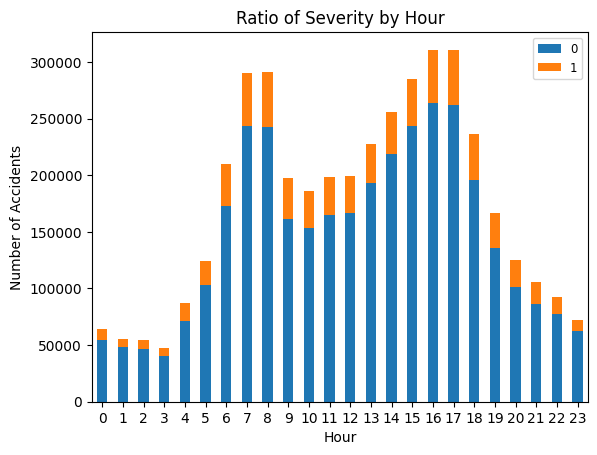

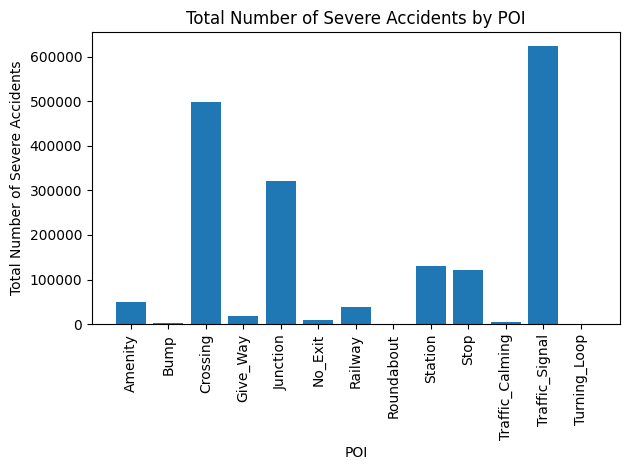

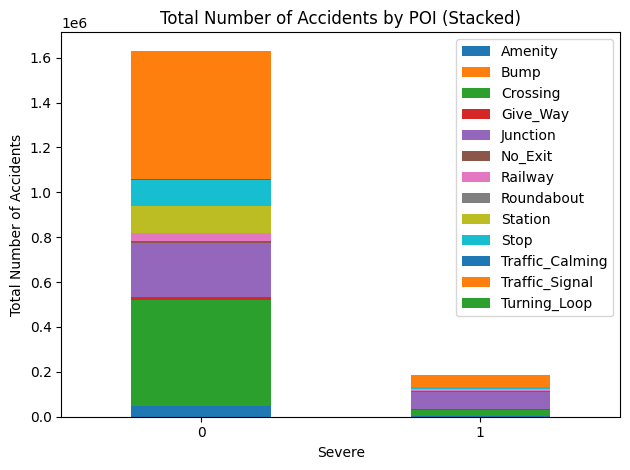

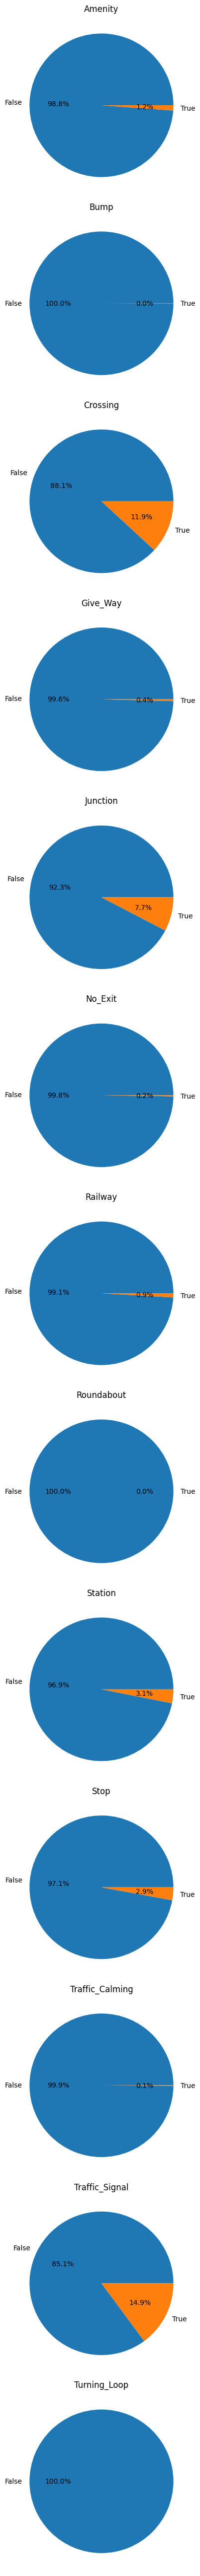

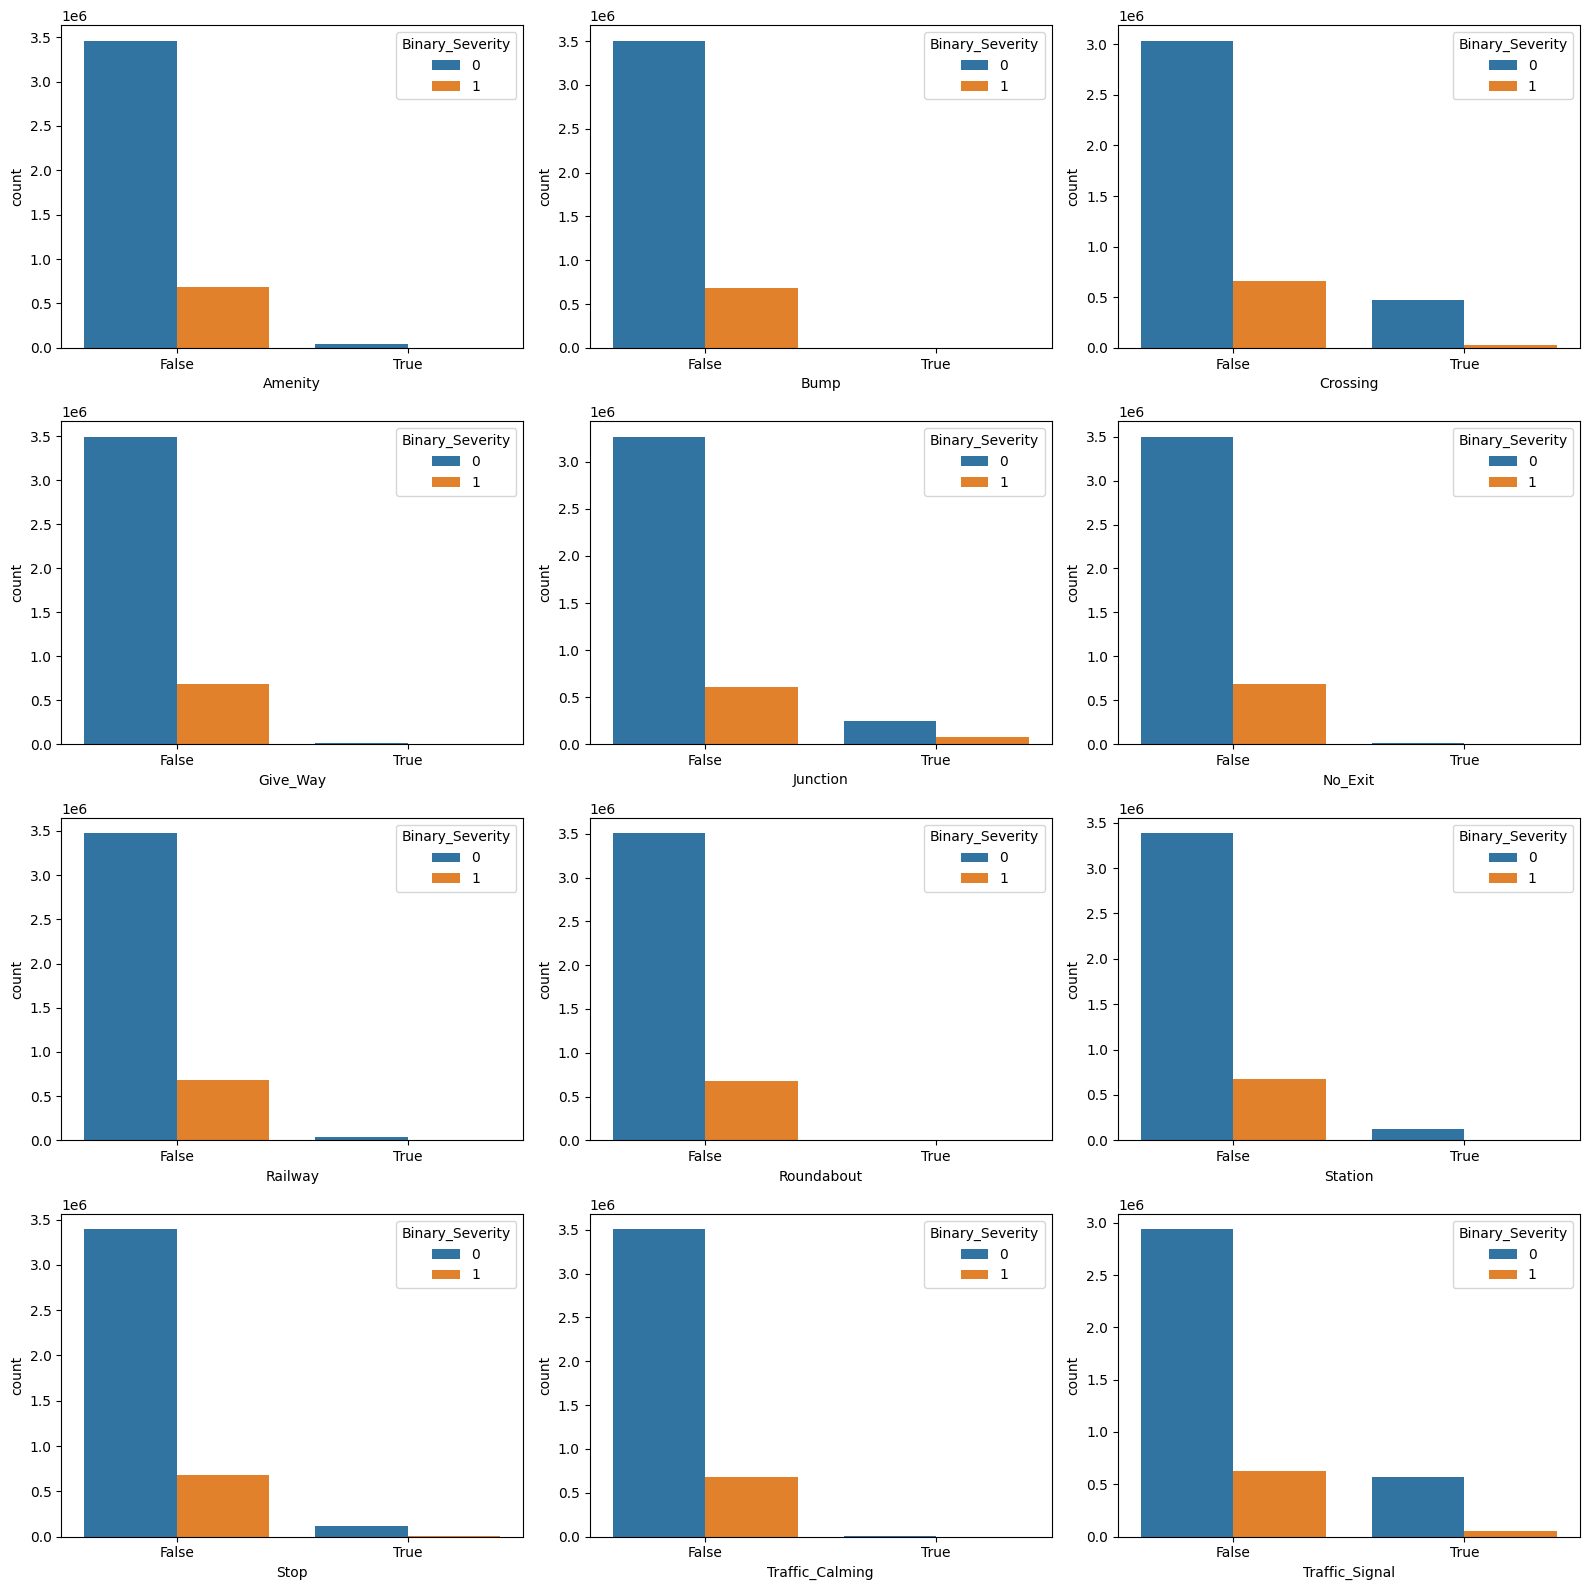

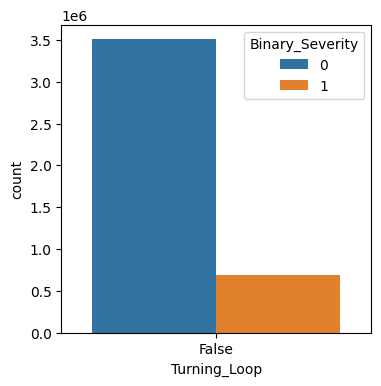

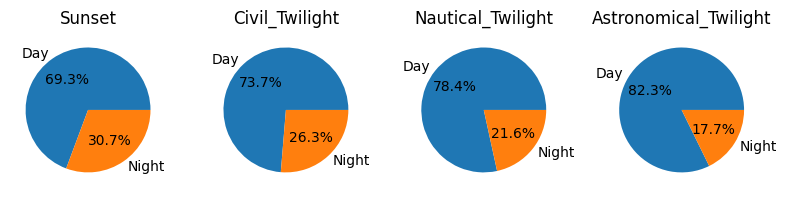

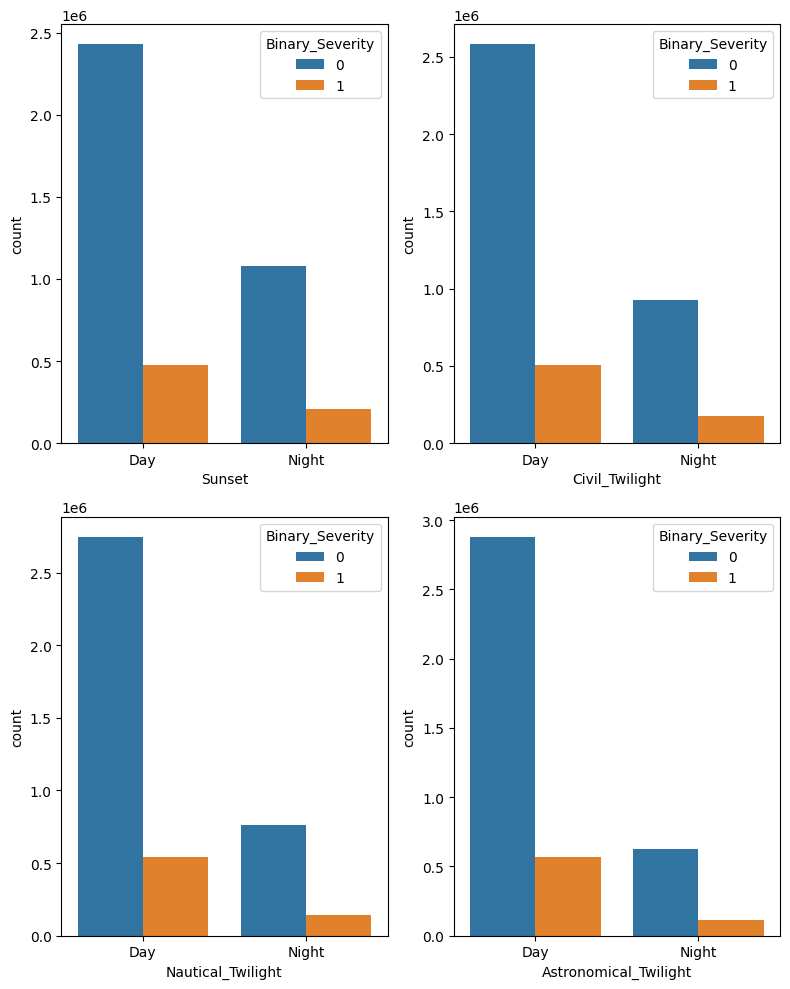

In [ ]:
run /content/drive/MyDrive/accidents/EDA.ipynb

In [ ]:
#due to the size of this dataset and for the sake of time, we will solely be focusing on California since it has the highest number of accidents.

# Create a list of states to keep
states_to_keep = ['CA']

# Create a new DataFrame by filtering the rows
cali_df = new_df[new_df['State'].isin(states_to_keep)]

In [ ]:
cali_df.head()

# EDA

### Number of Accidents per City

In [ ]:
#breakdown of the accidents by cities in California
cities_by_accident = cali_df.City.value_counts()
cities_by_accident[:20] #the top 20 cities

Los Angeles       155841
Sacramento         66059
San Diego          55330
San Jose           34412
Riverside          26262
Oakland            23562
San Bernardino     21934
Bakersfield        21306
Anaheim            21160
Long Beach         21009
Ontario            18530
Corona             18171
San Francisco      17756
Fresno             17157
Whittier           16446
Hayward            12659
Stockton           11502
Baldwin Park       10515
Irvine             10412
Tracy              10246
Name: City, dtype: int64

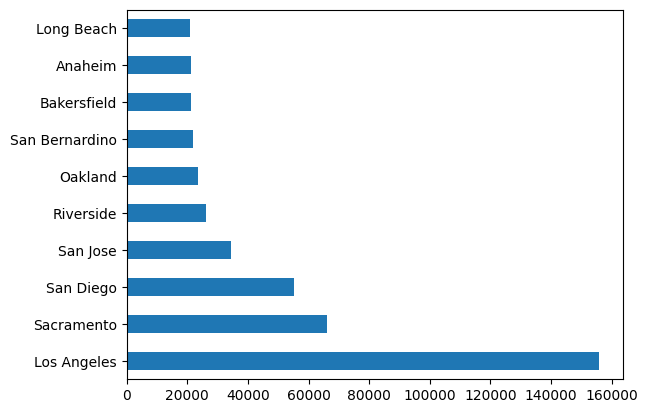

In [ ]:
cities_by_accident[:10].plot(kind = 'barh');

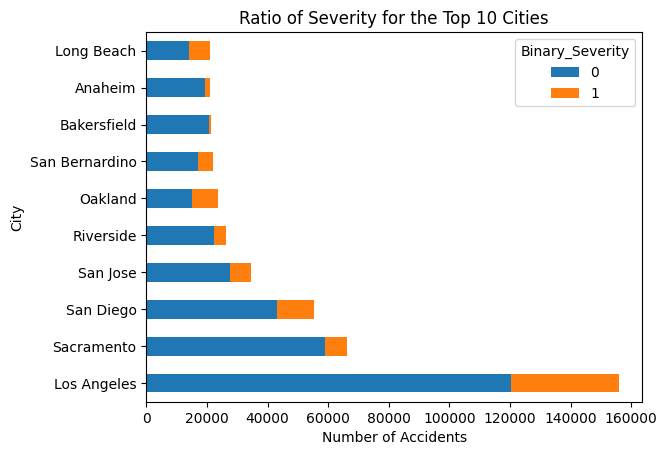

In [ ]:
#plotting the top 10 cities including the ratio of not severe to severe

# Select the relevant columns from the DataFrame
data_to_plot = cali_df[['City', 'Binary_Severity']]

# Group the data by 'City' and 'Binary_Severity' and count the occurrences
grouped_data = data_to_plot.groupby(['City', 'Binary_Severity']).size().unstack(fill_value=0)

# Sort the values by the sum of accidents in each city and select the top 10 cities
top_10_cities = grouped_data.sum(axis=1).sort_values(ascending=False).head(10).index

# Filter the grouped data to include only the top 10 cities
grouped_data_top_10 = grouped_data.loc[top_10_cities]

# Create a stacked bar plot
grouped_data_top_10.plot(kind='barh', stacked=True)

# Set the labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('City')
plt.title('Ratio of Severity for the Top 10 Cities')

# Show the plot
plt.show();

### Number of Accidents by Zipcode

In [ ]:
cali_df['Zipcode'].value_counts()

91761         11238
91706          9984
92407          8896
92507          8830
91765          7281
              ...  
90063-2238        1
95826-9703        1
94574-2012        1
92584-9699        1
92584-9564        1
Name: Zipcode, Length: 126415, dtype: int64

In [ ]:
#seeing which zipcode has the highest number of nonsevere accidents
cali_df[cali_df['Binary_Severity'] == 0].groupby('Zipcode').size().sort_values(ascending=False)

Zipcode
91761         8866
91765         7081
92507         6849
92407         6613
90012         6469
              ... 
96150-8661       1
96150-8674       1
96150-8809       1
96150-8811       1
96150-9217       1
Length: 125019, dtype: int64

In [ ]:
#seeing which zipcode has the highest number of severe accidents
cali_df[cali_df['Binary_Severity'] == 1].groupby('Zipcode').size().sort_values(ascending=False)

Zipcode
91706         4034
94607         2788
90248         2492
90650         2390
91761         2372
              ... 
90003-1762       1
96109-9659       1
96120-9538       1
96121            1
96122-8219       1
Length: 6120, dtype: int64

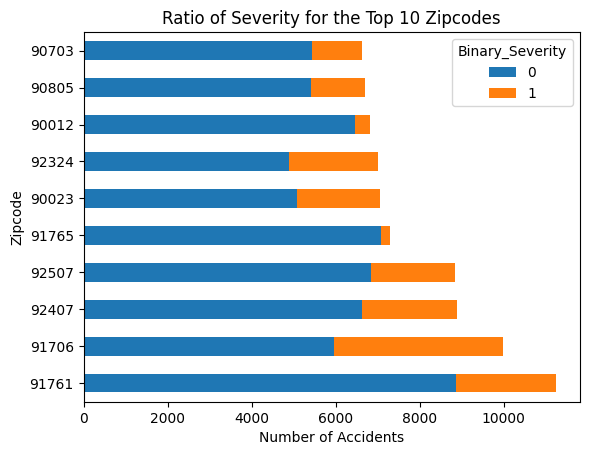

In [ ]:
# Select the relevant columns from the DataFrame
data_to_plot = cali_df[['Zipcode', 'Binary_Severity']]

# Group the data by 'Zipcode' and 'Binary_Severity' and count the occurrences
grouped_data = data_to_plot.groupby(['Zipcode', 'Binary_Severity']).size().unstack(fill_value=0)

# Sort the values by the sum of accidents in each zipcode and select the top 10 zipcodes
top_10_zipcodes = grouped_data.sum(axis=1).sort_values(ascending=False).head(10).index

# Filter the grouped data to include only the top 10 zipcode
grouped_data_top_10 = grouped_data.loc[top_10_zipcodes]

# Create a stacked bar plot
grouped_data_top_10.plot(kind='barh', stacked=True)

# Set the labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('Zipcode')
plt.title('Ratio of Severity for the Top 10 Zipcodes')

# Show the plot
plt.show();

The zipcode 91706 has higher ratio of severe accidents. That zipcode belongs to Baldwin Park, characterized as a suburban area. Suburban areas are generally more car dependent.

### Weighted frequency of words in the Weather_Condition column

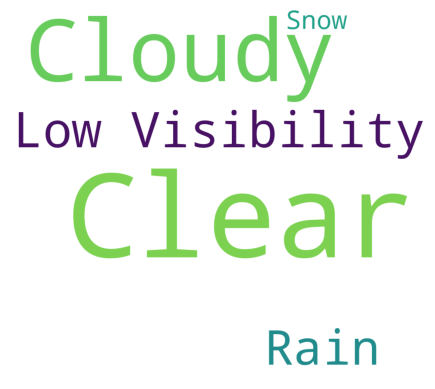

In [ ]:
#seeing which words in Weather_Condition has the most weights
data = cali_df['Weather_Condition'].value_counts().to_dict()
wc = WordCloud(width = 900, height = 800, background_color ='white', min_font_size = 10).generate_from_frequencies(data)
plt.imshow(wc)
plt.axis('off')
plt.show()

Interestingly, the majority of accidents occur under fair/clear or cloudy weather conditions rather than during snow or rain. This suggests that most people may prefer to avoid driving during inclement weather conditions.

### Total Number of Accidents by POI

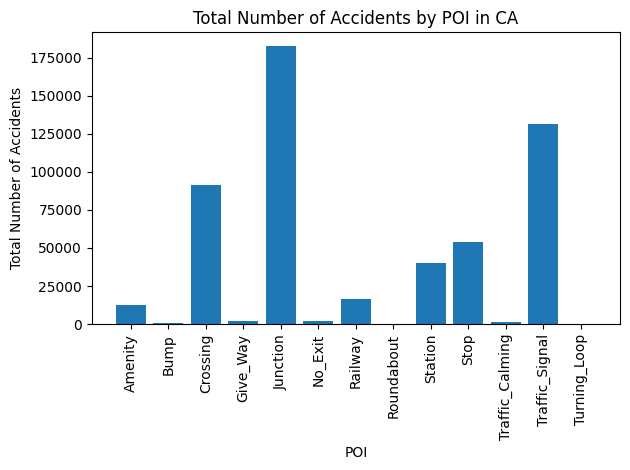

In [ ]:
columns_to_plot = ["Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
                   "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]

# Creating a new DataFrame with just the binary columns
binary_df = cali_df[columns_to_plot]

# Calculate the frequency of each binary value (0 or 1) in each column
binary_counts = binary_df.sum()

#plot
plt.bar(binary_counts.index, binary_counts.values)
plt.xlabel("POI")
plt.ylabel("Total Number of Accidents")
plt.title("Total Number of Accidents by POI in CA")
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

This shows a majority of accidents occurred at road Junctions in California as compared with the whole dataset, it was Traffic Signals.

### Number of Accidents per Hour

<ipython-input-33-81d22f5f329c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_df['Hour'] = cali_df['Start_Time'].dt.hour


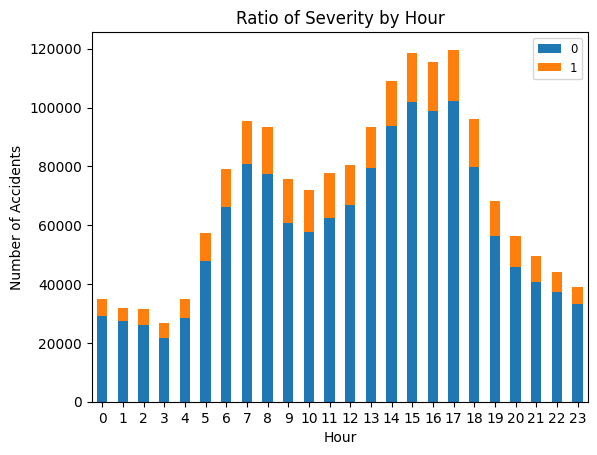

In [ ]:
# Extract the hour from the 'Start_Time' column
cali_df['Hour'] = cali_df['Start_Time'].dt.hour

# Select the relevant columns from the DataFrame
data_to_plot = cali_df[['Hour', 'Binary_Severity']]

# Group the data by 'Hour' and 'Binary_Severity' and count the occurrences
grouped_data = data_to_plot.groupby(['Hour', 'Binary_Severity']).size().unstack(fill_value=0)

# Sort the values by the sum of accidents in each hour of the day
hours = grouped_data.sum(axis=1).head(24).index

# Filter the grouped data to include all the hours
grouped_data_hour = grouped_data.loc[hours]

# Create a stacked bar plot
grouped_data_hour.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.title('Ratio of Severity by Hour')

# Rotate the x-axis labels
plt.xticks(rotation=360)

# Set the legend size
plt.legend(fontsize='small')

# Show the plot
plt.show();

As the number of accidents increases, the severity also appears to escalate.

### Number of Accidents per Month in California

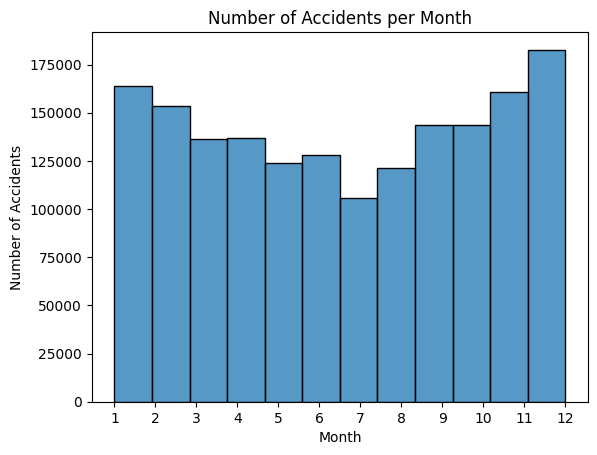

In [ ]:
sns.histplot(data=cali_df, x=cali_df.Start_Time.dt.month, bins=12)

plt.xticks(range(1, 13, 1))

plt.title('Number of Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.show();

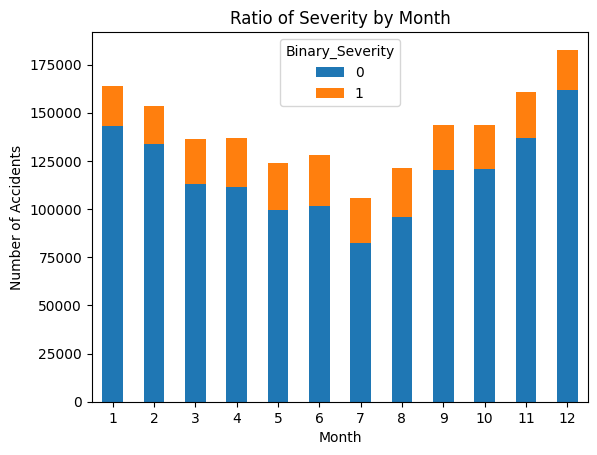

In [ ]:
# Select the relevant columns from the DataFrame
data_to_plot = cali_df[['Month', 'Binary_Severity']]

# Group the data by 'Month' and 'Binary_Severity' and count the occurrences
grouped_data = data_to_plot.groupby(['Month', 'Binary_Severity']).size().unstack(fill_value=0)

# Sort the values by the sum of accidents in each month
month = grouped_data.sum(axis=1).head(12).index

# Filter the grouped data to include all the months
grouped_data_month = grouped_data.loc[month]

# Create a stacked bar plot
grouped_data_month.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Ratio of Severity by Month')

# Rotate the x-axis labels
plt.xticks(rotation=360)

# Show the plot
plt.show();

As observed, there is a surge in accidents towards the end of the year, aligning with increased holiday travel.

### Number of Accidents per Year in California

In [ ]:
#creating a new column for the year of the accidents
cali_df['Year'] = cali_df['Start_Time'].dt.year

<ipython-input-36-a2b7884eeef1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_df['Year'] = cali_df['Start_Time'].dt.year


In [ ]:
cali_df['Year'].value_counts()

2022    366592
2021    333749
2020    277428
2019    208405
2018    153963
2017    150063
2016    138224
2023     72430
Name: Year, dtype: int64

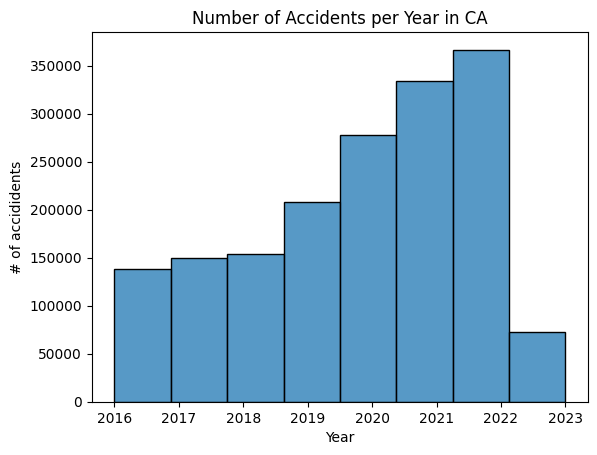

In [ ]:
ax = sns.histplot(data=cali_df, x=cali_df['Year'], bins=8)
ax.set_title('Number of Accidents per Year in CA')
ax.set_xlabel('Year')
ax.set_ylabel('# of accididents')
plt.show()

There has been a consistent increase in the number of accidents over the years.
> Note: Our records of accidents only extend up to March 2023.



# Modeling

In [ ]:
#installing catboost library
!pip install catboost

In [ ]:
pip install shap

In [ ]:
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, r2_score, log_loss, roc_auc_score
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

from scipy.stats import uniform

from collections import Counter

from sklearn.inspection import permutation_importance

import shap
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1700854 entries, 728 to 7728393
Data columns (total 45 columns):
 #   Column                            Dtype          
---  ------                            -----          
 0   ID                                object         
 1   Severity                          int64          
 2   Start_Time                        datetime64[ns] 
 3   End_Time                          datetime64[ns] 
 4   Start_Lat                         float64        
 5   Start_Lng                         float64        
 6   Distance(mi)                      float64        
 7   Description                       object         
 8   Street                            object         
 9   City                              object         
 10  County                            object         
 11  State                             object         
 12  Zipcode                           object         
 13  Weather_Timestamp                 datetime64[ns] 
 14  

In [ ]:
#defining the predictor/target variables
X = onehot_df.drop(columns=['Binary_Severity', 'Severity', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode',
                        'Weather_Timestamp', 'Start_Time', 'End_Time','Duration', 'ID'], axis=1)
y = onehot_df['Binary_Severity']

In [ ]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [ ]:
cali_df['Binary_Severity'].value_counts(normalize=True)

0    0.835694
1    0.164306
Name: Binary_Severity, dtype: float64

In [ ]:
#to address the class imbalanced, we willl be performing SMOTE
cali_df['Binary_Severity'].value_counts()

0    1421394
1     279460
Name: Binary_Severity, dtype: int64

## SMOTE

In [ ]:
smote = SMOTE(random_state=88)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

ss = StandardScaler()

ss.fit(X_train_resampled)

X_train_scaled = ss.transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_resampled))

Original dataset shape Counter({0: 1066162, 1: 209478})
Resample dataset shape Counter({1: 1066162, 0: 1066162})


### Logistic Regression with SMOTE

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train_scaled, y_train_resampled)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test_scaled)

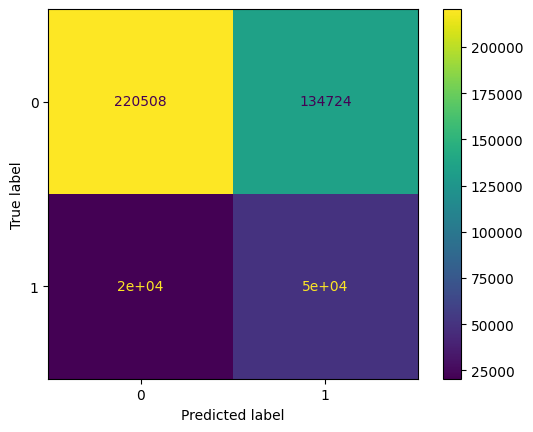

In [ ]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test);

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.6350543491042158

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74    355232
           1       0.27      0.71      0.39     69982

    accuracy                           0.64    425214
   macro avg       0.59      0.66      0.56    425214
weighted avg       0.81      0.64      0.68    425214



### Random Forest with SMOTE

In [ ]:
rf = RandomForestClassifier(random_state=88)

In [ ]:
rf.fit(X_train_resampled, y_train_resampled)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test);

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93    355232
           1       0.61      0.73      0.66     69982

    accuracy                           0.88    425214
   macro avg       0.78      0.82      0.79    425214
weighted avg       0.89      0.88      0.88    425214



In [ ]:
explainer = shap.Explainer(rf)

In [ ]:
X_test_subset = X_test[:10]

In [ ]:
shap_values = explainer.shap_values(X_test_subset)

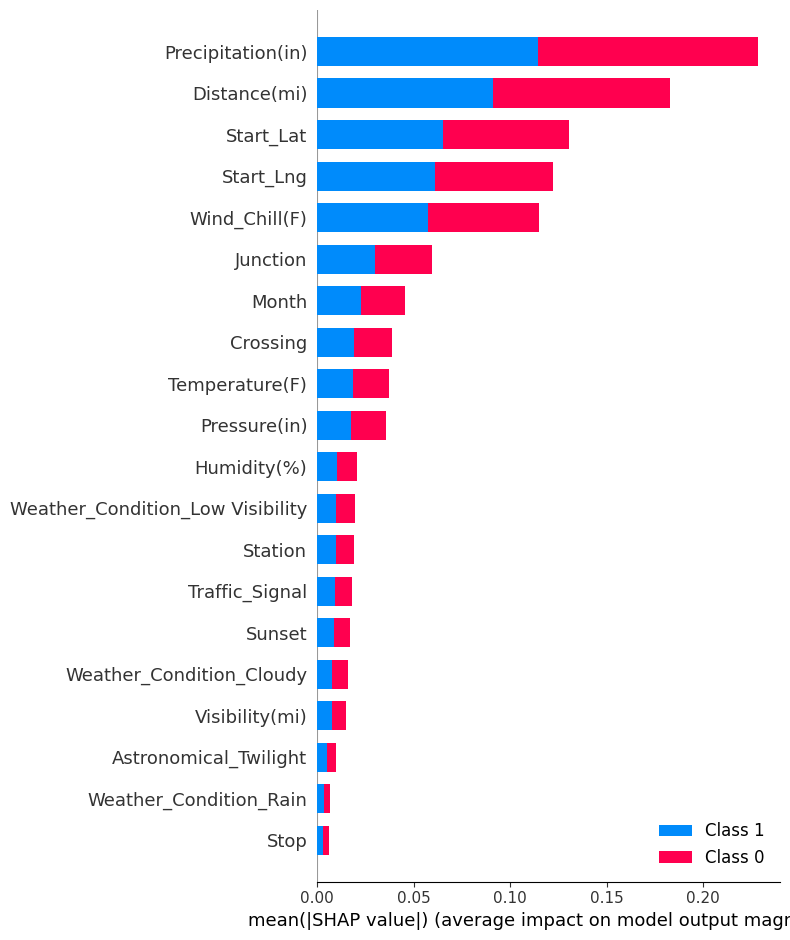

In [ ]:
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
shap.initjs() #allows us to display SHAP plots here
shap.plots.force(explainer.expected_value[0], shap_values[0])


### Tuning Hyperparameters with GridSearchCV: Random Forest

In [ ]:
pipe = Pipeline([('random_forest', RandomForestClassifier(random_state=88))])

params = {'random_forest__n_estimators': np.arange(20,100,40),
          'random_forest__criterion':['entropy'],
          'random_forest__max_depth': np.arange(8,12,2)}

grid = GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestClassifier(random_state=88))]),
             param_grid={'random_forest__criterion': ['entropy'],
                         'random_forest__max_depth': array([ 8, 10]),
                         'random_forest__n_estimators': array([20, 60])})

In [ ]:
best_est = grid.best_estimator_
best_est

Pipeline(steps=[('random_forest',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=60, random_state=88))])

In [ ]:
#running Random Forest with the best parameters
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=60,
                       random_state=88)
rf_clf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred_rf)

0.7759363520486156

### RandomizedSearchCV: Logistic Regression

In [ ]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=88)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
rand_search = RandomizedSearchCV(logistic, distributions, random_state=88)
search = rand_search.fit(X_train_scaled, y_train_resampled)
search.best_params_

### GridSearchCV: Logisitic Regression

In [ ]:
logreg_pipe = Pipeline([("logreg", LogisticRegression(random_state=88))])

params = {'logreg__C': [0.01, 0.1, 1],
          'logreg__class_weight': ['balanced'],
          'logreg__penalty': ['l1'],
          'logreg__solver': ['liblinear', 'saga']}

grid_logreg = GridSearchCV(logreg_pipe, param_grid=params, cv=5, error_score='raise')
grid_logreg.fit(X_train_scaled, y_train_resampled)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(random_state=88))]),
             param_grid={'logreg__C': [0.01, 0.1, 1],
                         'logreg__class_weight': ['balanced'],
                         'logreg__penalty': ['l1'],
                         'logreg__solver': ['liblinear', 'saga']})

In [ ]:
best_est = grid_logreg.best_estimator_
best_est

Pipeline(steps=[('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    penalty='l1', random_state=88,
                                    solver='liblinear'))])

In [ ]:
tuned_logreg = LogisticRegression(C=0.3596887787358143, class_weight='balanced', penalty='l1',
                   random_state=88, solver='liblinear')

tuned_logreg.fit(X_train_scaled, y_train_resampled)

y_pred = tuned_logreg.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

X has feature names, but LogisticRegression was fitted without feature names


0.8354193417902515

In [ ]:
tuned_logreg = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=88, solver='liblinear')

tuned_logreg.fit(X_train_scaled, y_train_resampled)

y_pred = tuned_logreg.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

X has feature names, but LogisticRegression was fitted without feature names


0.8354193417902515

# Catboost Model

In [ ]:
#defining the predictor/target variables
X = cali_df.drop(columns=['Binary_Severity', 'Severity', 'State', 'Street',
                        'Weather_Timestamp', 'Start_Time', 'End_Time','Duration', 'ID'], axis=1)
y = cali_df['Binary_Severity']

In [ ]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [ ]:
#we have class imbalanced
y.value_counts(normalize=True)

0    0.835694
1    0.164306
Name: Binary_Severity, dtype: float64

In [ ]:
#setting the categorical features to the variable, cat_features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [ ]:
cb_clf = CatBoostClassifier(cat_features=cat_features, auto_class_weights='Balanced', task_type='GPU', random_state=88)

In [ ]:
cb_clf.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.022749
0:	learn: 0.6755979	total: 56.5ms	remaining: 56.4s
1:	learn: 0.6589662	total: 106ms	remaining: 52.7s
2:	learn: 0.6433250	total: 155ms	remaining: 51.4s
3:	learn: 0.6286392	total: 204ms	remaining: 50.7s
4:	learn: 0.6146422	total: 252ms	remaining: 50.1s
5:	learn: 0.6016253	total: 300ms	remaining: 49.6s
6:	learn: 0.5892390	total: 345ms	remaining: 49s
7:	learn: 0.5774013	total: 393ms	remaining: 48.7s
8:	learn: 0.5665519	total: 441ms	remaining: 48.5s
9:	learn: 0.5560950	total: 489ms	remaining: 48.4s
10:	learn: 0.5461196	total: 542ms	remaining: 48.7s
11:	learn: 0.5368573	total: 590ms	remaining: 48.5s
12:	learn: 0.5280252	total: 638ms	remaining: 48.4s
13:	learn: 0.5198495	total: 684ms	remaining: 48.2s
14:	learn: 0.5122699	total: 734ms	remaining: 48.2s
15:	learn: 0.5048764	total: 780ms	remaining: 47.9s
16:	learn: 0.4978617	total: 829ms	remaining: 47.9s
17:	learn: 0.4913323	total: 875ms	remaining: 47.7s
18:	learn: 0.4852117	total: 920ms	remaining: 47.5s
19:	learn: 0

In [ ]:
class_predictions = cb_clf.predict(X_test)

In [ ]:
probability_predictions = cb_clf.predict_proba(X_test)

In [ ]:
roc_auc = roc_auc_score(y_test, probability_predictions[:,1])
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9378224237011261


In [ ]:
class_report = classification_report(y_test, class_predictions)
print(f'Classification Report:\n {class_report}')

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91    355232
           1       0.54      0.89      0.67     69982

    accuracy                           0.86    425214
   macro avg       0.76      0.87      0.79    425214
weighted avg       0.90      0.86      0.87    425214



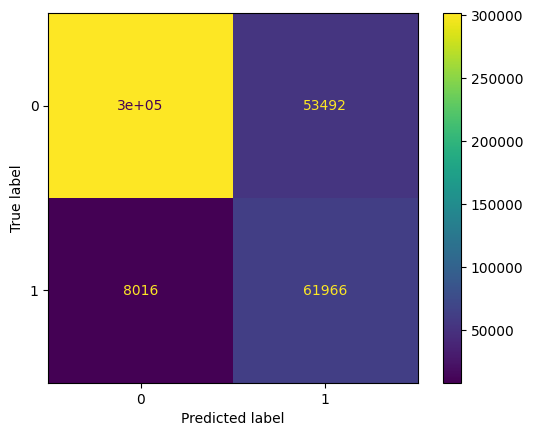

In [ ]:
ConfusionMatrixDisplay.from_estimator(cb_clf, X_test, y_test);

## Catboost Parameter Tuning

In [ ]:
cat_pipe = Pipeline([("catboost", CatBoostClassifier(task_type='GPU', random_state=88))])

params = {'catboost__depth': [16],
          'catboost__auto_class_weights': ['Balanced'], #this deals with the class imbalanced
          'catboost__cat_features': [cat_features],
          'catboost__learning_rate': [0.1,0.15],
          'catboost__iterations': [125,130]}

cat_grid = GridSearchCV(cat_pipe, param_grid=params, cv=5, error_score='raise')
cat_grid.fit(X_train, y_train)

0:	learn: 0.6242380	total: 2.49s	remaining: 5m 8s
1:	learn: 0.5707459	total: 4.95s	remaining: 5m 4s
2:	learn: 0.5274789	total: 7.42s	remaining: 5m 1s
3:	learn: 0.4951783	total: 9.89s	remaining: 4m 59s
4:	learn: 0.4695378	total: 12.3s	remaining: 4m 56s
5:	learn: 0.4504607	total: 14.8s	remaining: 4m 53s
6:	learn: 0.4230828	total: 17.3s	remaining: 4m 51s
7:	learn: 0.4031195	total: 19.7s	remaining: 4m 48s
8:	learn: 0.3867304	total: 22.2s	remaining: 4m 46s
9:	learn: 0.3746112	total: 24.7s	remaining: 4m 43s
10:	learn: 0.3640096	total: 27.1s	remaining: 4m 41s
11:	learn: 0.3557253	total: 29.6s	remaining: 4m 38s
12:	learn: 0.3481094	total: 32.1s	remaining: 4m 36s
13:	learn: 0.3425943	total: 34.5s	remaining: 4m 33s
14:	learn: 0.3380905	total: 37s	remaining: 4m 31s
15:	learn: 0.3341021	total: 39.5s	remaining: 4m 28s
16:	learn: 0.3304223	total: 41.9s	remaining: 4m 26s
17:	learn: 0.3268306	total: 44.4s	remaining: 4m 23s
18:	learn: 0.3235209	total: 46.9s	remaining: 4m 21s
19:	learn: 0.3212961	total:

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x78957bdd5540>)]),
             param_grid={'catboost__auto_class_weights': ['Balanced'],
                         'catboost__cat_features': [['City', 'County',
                                                     'Zipcode',
                                                     'Weather_Condition']],
                         'catboost__depth': [16],
                         'catboost__iterations': [125, 130],
                         'catboost__learning_rate': [0.1, 0.15]})

In [ ]:
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n",cat_grid.best_estimator_)
    print("\n The best score across ALL searched params:\n",cat_grid.best_score_)
    print("\n The best parameters across ALL searched params:\n",cat_grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('catboost',
                 <catboost.core.CatBoostClassifier object at 0x78957bdd4cd0>)])

 The best score across ALL searched params:
 0.8860642501019097

 The best parameters across ALL searched params:
 {'catboost__auto_class_weights': 'Balanced', 'catboost__cat_features': ['City', 'County', 'Zipcode', 'Weather_Condition'], 'catboost__depth': 16, 'catboost__iterations': 130, 'catboost__learning_rate': 0.15}


In [ ]:
#using the best parameters for Catboost model

tuned_cat = CatBoostClassifier(cat_features=cat_features, auto_class_weights='Balanced', depth=16, iterations=130,
                               learning_rate=0.15, task_type='GPU', random_state=88)

tuned_cat.fit(X_train, y_train)

y_pred = tuned_cat.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

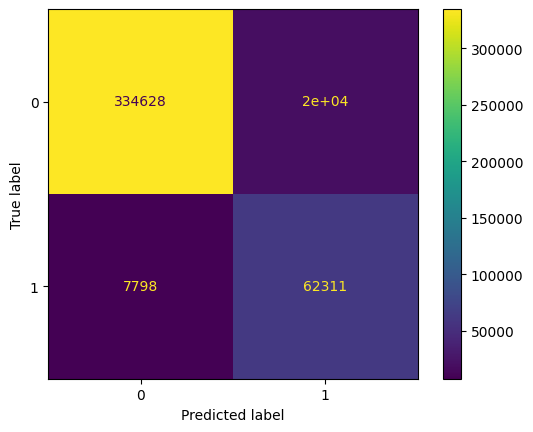

In [ ]:
ConfusionMatrixDisplay.from_estimator(tuned_cat, X_test, y_test);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    355104
           1       0.75      0.89      0.82     70109

    accuracy                           0.93    425213
   macro avg       0.86      0.92      0.89    425213
weighted avg       0.94      0.93      0.94    425213



In [ ]:
feature_results = pd.DataFrame({'feature':X_train.columns,
                                'importance':tuned_cat.feature_importances_
                               })
feature_results = feature_results.sort_values('importance',ascending=False).reset_index(drop=True)

<Figure size 1200x1200 with 0 Axes>

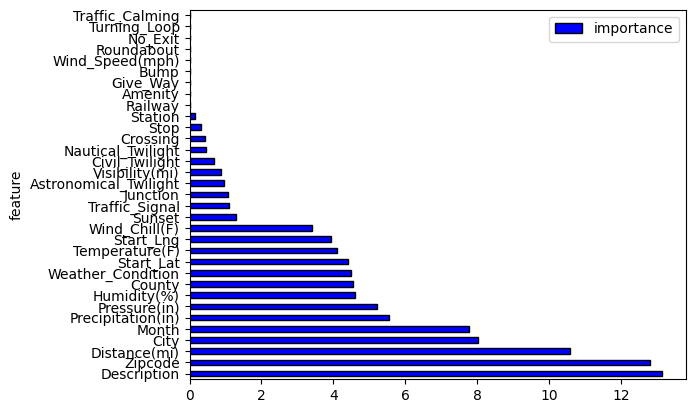

In [ ]:
plt.figure(figsize=(12,12))

feature_results.plot(x = 'feature', y='importance',edgecolor = 'k',kind='barh',color='blue');

# Feature Importance by Class


In [ ]:
#function that plots feature importance
def plot_feature_importances(model, x, y, title):
    result = permutation_importance(model, x, y, n_repeats=100, random_state=88)
    df = pd.DataFrame({'feature_name': x.columns, 'feature_importance': result.importances_mean})
    plt.figure(figsize=(8, 8))
    sns.barplot(data=df, x='feature_importance', y='feature_name')
    plt.title(title)
    plt.show()

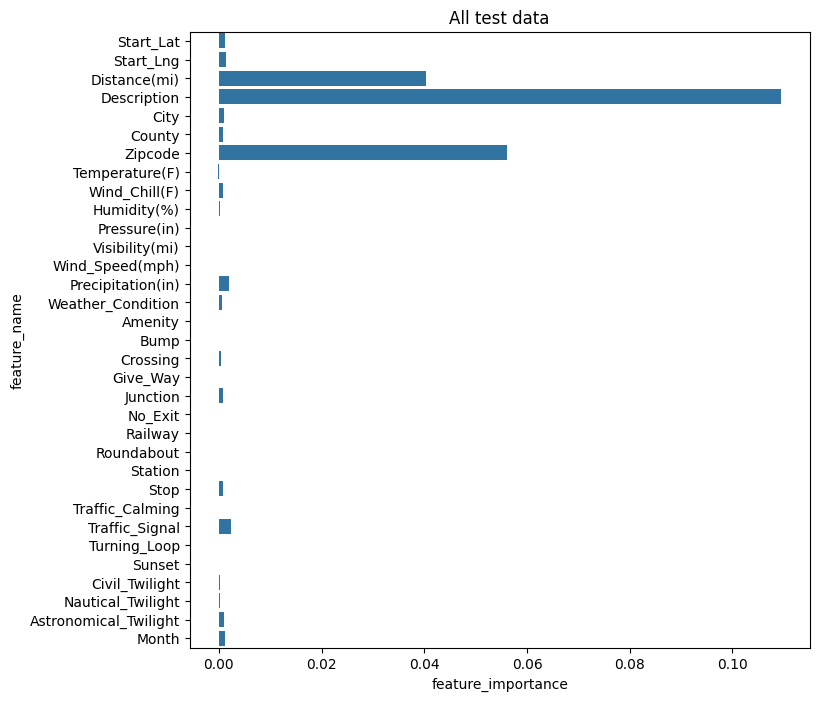

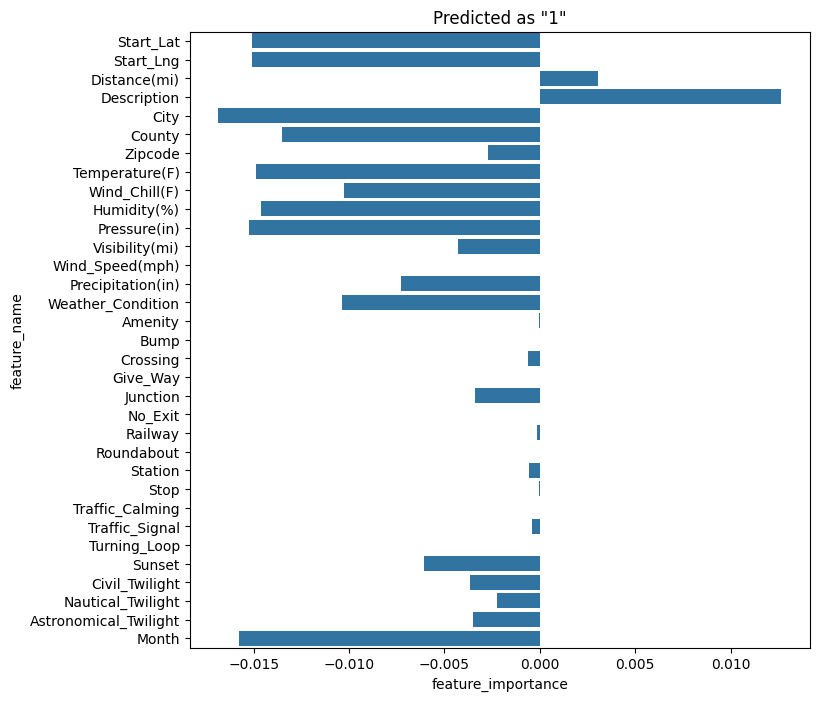

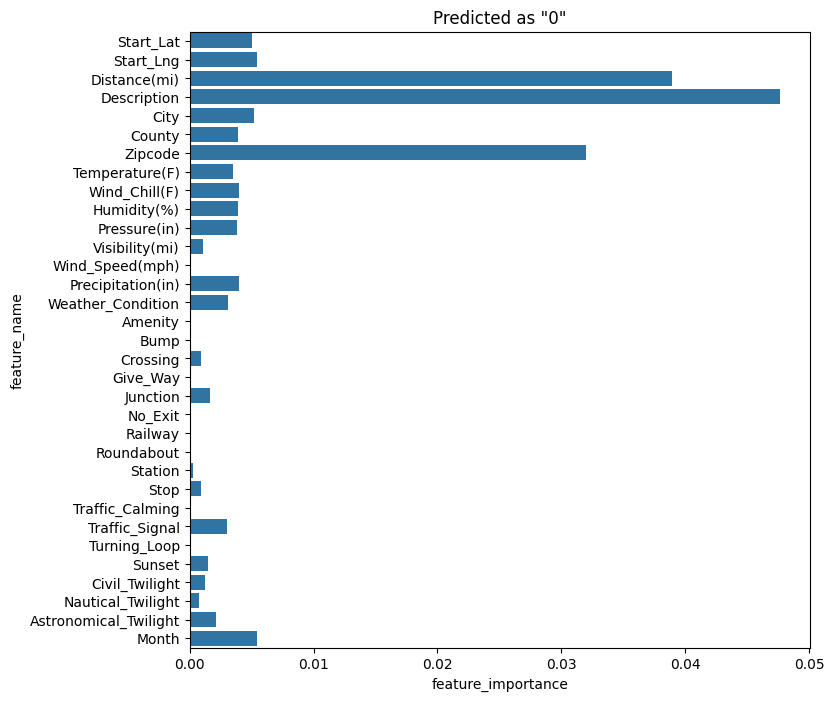

In [ ]:
#visualizing the feature importance

plot_feature_importances(tuned_cat, X_test, y_test, 'All test data')

y_pred = tuned_cat.predict(X_test)
plot_feature_importances(tuned_cat, X_test[y_pred == 1], y_test[y_pred == 1], 'Predicted as "1"')
plot_feature_importances(tuned_cat, X_test[y_pred == 0], y_test[y_pred == 0], 'Predicted as "0"');

# SHAP Catboost

In [ ]:
explainer = shap.Explainer(tuned_cat)

In [ ]:
#using a subset of X_test because it's impossible to run the entire test
X_test_subset = X_test[:1000]

In [ ]:
shap_values = explainer.shap_values(X_test_subset)

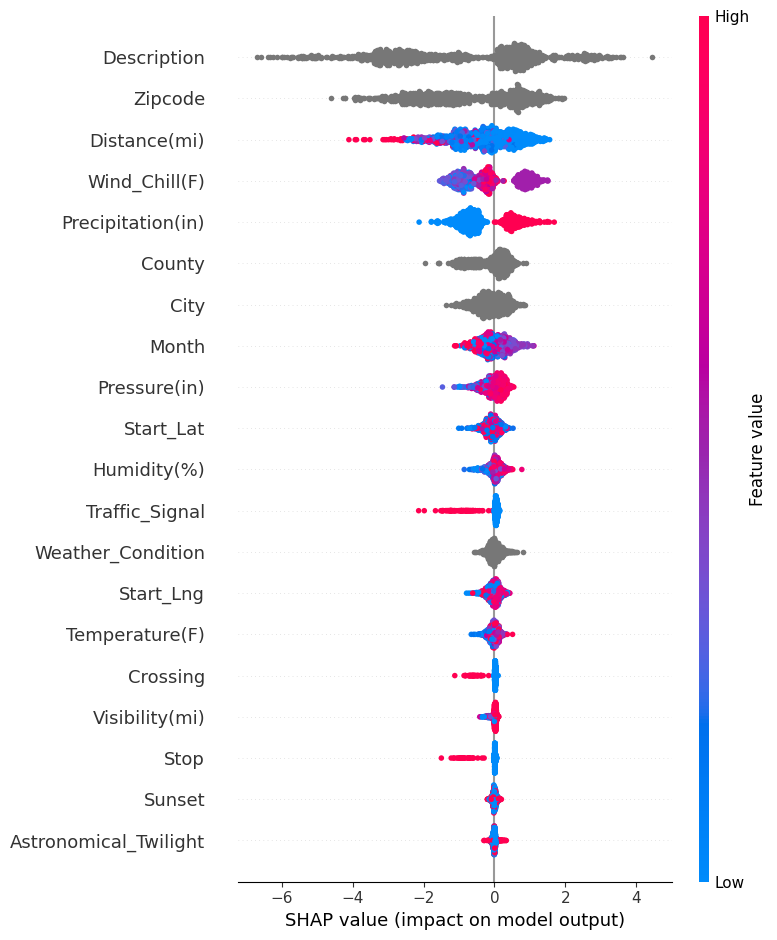

In [ ]:
shap.summary_plot(shap_values, X_test_subset)

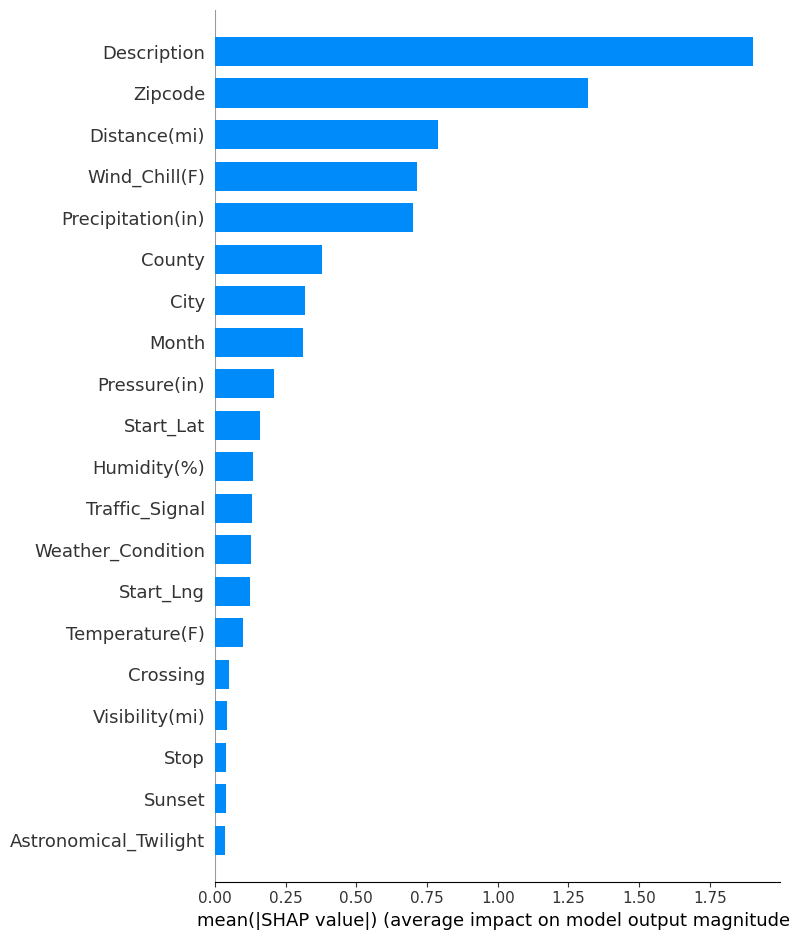

In [ ]:
shap.summary_plot(shap_values, X_test_subset, plot_type="bar")

In [ ]:
shap_values = explainer(X_test_subset)

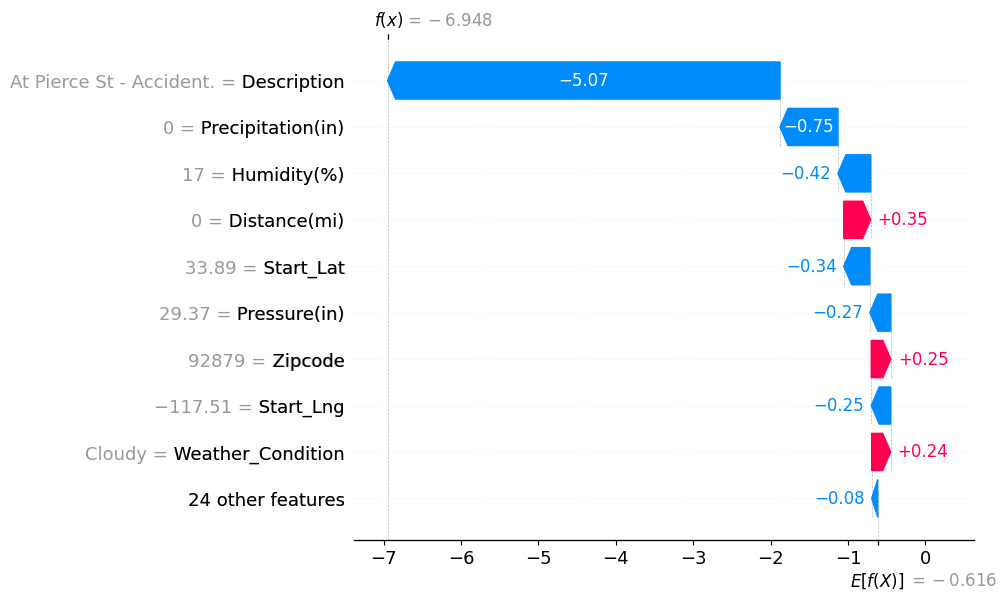

In [ ]:
#waterfall plot for the 888 observation
shap.plots.waterfall(shap_values[888])